# Voltage-Dependent Steady State Comparison
## Investigating why 10V and 30V converge to identical steady states

**Problem**: In continuous simulation, different voltages (10V vs 30V) reach the SAME steady state,
but training data shows voltage-dependent behavior (10V: low CALA, 30V: high CALA).

**Hypothesis**: LSTM's long-term dependency weakens over time, causing voltage effects to dissipate.

In [49]:
# import module libraries
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

In [50]:
# Copy model class definitions from 7.bmed_1stage_simulator.ipynb
# (LayerNormLSTM, StateExtr, PhysRegr, CurrRegr, PhysConstr, BMEDModel)

# LSTM with layer normalization
class LayerNormLSTM(nn.Module):
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node

        self.w_i = nn.Linear(input_node, 4*hidden_node, bias=False)
        self.w_h = nn.Linear(hidden_node, 4*hidden_node, bias=False)

        self.ln_i = nn.LayerNorm(hidden_node)
        self.ln_f = nn.LayerNorm(hidden_node)
        self.ln_w = nn.LayerNorm(hidden_node)
        self.ln_o = nn.LayerNorm(hidden_node)
        self.ln_c = nn.LayerNorm(hidden_node)

    def forward(self, input, hidden):
        h_prev, c_prev = hidden

        gi = self.w_i(input)
        gh = self.w_h(h_prev)
        i_i, i_f, i_w, i_o = gi.chunk(4, dim=-1)
        h_i, h_f, h_w, h_o = gh.chunk(4, dim=-1)

        i_g = torch.sigmoid(self.ln_i(i_i + h_i))
        f_g = torch.sigmoid(self.ln_f(i_f + h_f))
        w_g = torch.tanh(self.ln_w(i_w + h_w))
        o_g = torch.sigmoid(self.ln_o(i_o + h_o))

        c_new = f_g * c_prev + i_g * w_g
        c_new = self.ln_c(c_new)

        h_new = o_g * torch.tanh(c_new)

        return h_new, c_new

# State feature extractor using LayerNorm LSTM
class StateExtr(nn.Module):
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        self.hidden_node = hidden_node
        self.n_layer = n_layer
        self.input_node = input_node

        self.lstm_cells = nn.ModuleList()
        self.lstm_cells.append(LayerNormLSTM(input_node, hidden_node))

        for i in range(n_layer - 1):
            self.lstm_cells.append(LayerNormLSTM(hidden_node, hidden_node))

        self.dropout = nn.Dropout(dropout)
        self.layernorm = nn.LayerNorm(hidden_node)

    def forward(self, x, seq_len):
        batch_size, max_len, _ = x.size()
        device = x.device

        h_states = []
        c_states = []

        for _ in range(self.n_layer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))

        outputs = []
        for t in range(max_len):
            x_t = x[:, t, :]

            layer_input = x_t
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))
                
                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new

                if layer_idx < len(self.lstm_cells) - 1:
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new

            outputs.append(layer_input)

        output_tensor = torch.stack(outputs, dim=1)
        seq_len_cpu = seq_len.detach().cpu().long()
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)

        masked_output = output_tensor * mask
        normed_output = self.layernorm(masked_output)
        return self.dropout(normed_output)

# Physical change regressor
class PhysRegr(nn.Module):
    def __init__(self, input_node, output_node, n_layer, hidden_node, dropout):
        super().__init__()

        layers = []

        layers.extend([
            nn.Linear(input_node, hidden_node),
            nn.LayerNorm(hidden_node),
            nn.ReLU(),
            nn.Dropout(dropout)
        ])

        for _ in range(n_layer - 1):
            layers.extend([
                nn.Linear(hidden_node, hidden_node),
                nn.LayerNorm(hidden_node),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        
        layers.append(nn.Linear(hidden_node, output_node))
        layers.append(nn.Sigmoid())

        self.layers = nn.Sequential(*layers)

    def forward(self, hidden_states):
        return self.layers(hidden_states)

# Current regressor
class CurrRegr(nn.Module):
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()

        layers = []

        layers.extend([
            nn.Linear(input_node, hidden_node),
            nn.LayerNorm(hidden_node),
            nn.ReLU(),
            nn.Dropout(dropout)
        ])

        for _ in range(n_layer - 1):
            layers.extend([
                nn.Linear(hidden_node, hidden_node),
                nn.LayerNorm(hidden_node),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        
        layers.append(nn.Linear(hidden_node, 1))

        self.layers = nn.Sequential(*layers)

    def forward(self, hidden_states):
        return self.layers(hidden_states)

# Physical Constraint Layer
class PhysConstr(nn.Module):
    def __init__(self, range_mm, curr_regr, eps=1e-2):
        super().__init__()
        
        self.eps = eps
        self.curr_regr = curr_regr
        self.register_buffer('range_mm_tensor',self._range2tensor(range_mm))

    def _range2tensor(self, range_mm):
        feature_names = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
        ranges = torch.zeros(len(feature_names), 2)

        for i, name in enumerate(feature_names):
            ranges[i, 0] = range_mm[name]['min']
            ranges[i, 1] = range_mm[name]['max']

        return ranges

    def _norm_tensor(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return (data - min_val) / (max_val - min_val)

    def _denorm_tensor(self, norm_data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return norm_data * (max_val - min_val) + min_val

    def forward(self, phys_chng, cur_state, fin, initV):
        V_idx, E_idx, VF_idx, VA_idx, VB_idx = 0, 1, 2, 3, 4
        CFLA_idx, CALA_idx, CFK_idx, CBK_idx, I_idx = 5, 6, 7, 8, 9

        VF = self._denorm_tensor(cur_state[..., 2:3], VF_idx)
        VA = self._denorm_tensor(cur_state[..., 3:4], VA_idx)
        VB = self._denorm_tensor(cur_state[..., 4:5], VB_idx)
        CFLA = self._denorm_tensor(cur_state[..., 5:6], CFLA_idx)
        CALA = self._denorm_tensor(cur_state[..., 6:7], CALA_idx)
        CFK = self._denorm_tensor(cur_state[..., 7:8], CFK_idx)
        CBK = self._denorm_tensor(cur_state[..., 8:9], CBK_idx)

        FvF, FvA, FvB, CiLA, CiK = fin
        VFi, VAi, VBi = initV

        dVF_in, dVA_in, dVB_in = FvF, FvA, FvB
        dNFLA_in, dNFK_in = FvF * CiLA, FvF * CiK

        rdVA = phys_chng[..., 0:1]
        rdVB = phys_chng[..., 1:2]
        rdNALA = phys_chng[..., 2:3]
        rdNBK = phys_chng[..., 3:4]

        NFLA = CFLA * VF
        NALA = CALA * VA
        NFK = CFK * VF
        NBK = CBK * VB

        VF_after_feed = VF + dVF_in
        VA_after_feed = VA + dVA_in
        VB_after_feed = VB + dVB_in
        NFLA_after_feed = NFLA + dNFLA_in
        NALA_after_feed = NALA
        NFK_after_feed = NFK + dNFK_in
        NBK_after_feed = NBK

        dVA = VF_after_feed * (rdVA - 0.5)
        dVB = VF_after_feed * (rdVB - 0.5)
        dNALA = NFLA_after_feed * rdNALA
        dNBK = NFK_after_feed * rdNBK

        nVF_bf = VF_after_feed - dVA - dVB
        nVA_bf = VA_after_feed + dVA
        nVB_bf = VB_after_feed + dVB

        nNFLA_bf = NFLA_after_feed - dNALA
        nNALA_bf = NALA_after_feed + dNALA
        nNFK_bf = NFK_after_feed - dNBK
        nNBK_bf = NBK_after_feed + dNBK

        nCFLA = nNFLA_bf / nVF_bf
        nCALA = nNALA_bf / nVA_bf
        nCFK = nNFK_bf / nVF_bf
        nCBK = nNBK_bf / nVB_bf

        dVF_out = nVF_bf - VFi
        dVA_out = nVA_bf - VAi
        dVB_out = nVB_bf - VBi

        nVF = torch.where(dVF_out > 0, nVF_bf - dVF_out, nVF_bf)
        nVA = torch.where(dVA_out > 0, nVA_bf - dVA_out, nVA_bf)
        nVB = torch.where(dVB_out > 0, nVB_bf - dVB_out, nVB_bf)
        
        dNFLA_out = torch.where(dVF_out > 0, nCFLA * dVF_out, torch.zeros_like(dVF_out))
        dNFK_out = torch.where(dVF_out > 0, nCFK * dVF_out, torch.zeros_like(dVF_out))
        dNALA_out = torch.where(dVA_out > 0, nCALA * dVA_out, torch.zeros_like(dVA_out))
        dNBK_out = torch.where(dVB_out > 0, nCBK * dVB_out, torch.zeros_like(dVB_out))

        nNFLA = nNFLA_bf - dNFLA_out
        nNALA = nNALA_bf - dNALA_out
        nNFK = nNFK_bf - dNFK_out
        nNBK = nNBK_bf - dNBK_out

        V = cur_state[..., 0:1]
        E = cur_state[..., 1:2]

        nVF_norm = self._norm_tensor(nVF, VF_idx)
        nVA_norm = self._norm_tensor(nVA, VA_idx)
        nVB_norm = self._norm_tensor(nVB, VB_idx)
        nCFLA_norm = self._norm_tensor(nCFLA, CFLA_idx)
        nCALA_norm = self._norm_tensor(nCALA, CALA_idx)
        nCFK_norm = self._norm_tensor(nCFK, CFK_idx)
        nCBK_norm = self._norm_tensor(nCBK, CBK_idx)

        temp_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm
        ], dim=-1)

        nI_pred = self.curr_regr(temp_state)
        nI_real = self._denorm_tensor(nI_pred, I_idx)
        nI_real = torch.clamp(nI_real, min=0.0)
        nI_norm = self._norm_tensor(nI_real, I_idx)

        next_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm, nI_norm
        ], dim=-1)

        discharge = {
            'VF': dVF_out,
            'VA': dVA_out,
            'VB': dVB_out,
            'NFLA': dNFLA_out,
            'NALA': dNALA_out,
            'NFK': dNFK_out,
            'NBK': dNBK_out,
            'CFLA': nCFLA,
            'CALA': nCALA,
            'CFK': nCFK,
            'CBK': nCBK
        }

        return next_state, discharge

# BMED model
class BMEDModel(nn.Module):
    def __init__(self, state_extr_params, phys_regr_params, curr_regr_params, range_mm):
        super().__init__()
        self.state_extr = StateExtr(**state_extr_params)
        self.phys_regr = PhysRegr(**phys_regr_params)
        self.curr_regr = CurrRegr(**curr_regr_params)
        self.phys_constr = PhysConstr(range_mm, self.curr_regr)

        self._hidden_states = None
        self._cell_states = None

    def _reset_hidden_states(self, batch_size, device):
        self._hidden_states = []
        self._cell_states = []
        for _ in range(self.state_extr.n_layer):
            self._hidden_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))
            self._cell_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))

    def cont_sim(self, init_state, target_len, fin, initV):
        batch_size = init_state.size(0)
        feature_size = init_state.size(1)
        device = init_state.device

        self._reset_hidden_states(batch_size, device)

        pred = torch.zeros(batch_size, target_len, feature_size, device=device)
        discharge_record = []
        cur_state = init_state.clone()

        for t in range(target_len):
            pred[:, t, :] = cur_state

            if t < target_len - 1:
                lstm_input = cur_state[:, :-1]
                hidden_output = self._lstm_single_step(lstm_input)

                phys_chng = self.phys_regr(hidden_output.unsqueeze(1))
                cur_state_expanded = cur_state.unsqueeze(1)

                next_state, discharge = self.phys_constr(
                    phys_chng, cur_state_expanded, fin, initV
                )

                cur_state = next_state.squeeze(1)
                discharge_record.append(discharge)
        return pred, discharge_record

    def _lstm_single_step(self, x_t):
        layer_input = x_t

        for layer_idx, lstm_cell in enumerate(self.state_extr.lstm_cells):
            h_new, c_new = lstm_cell(layer_input, (self._hidden_states[layer_idx], self._cell_states[layer_idx]))
            
            self._hidden_states[layer_idx] = h_new
            self._cell_states[layer_idx] = c_new

            if layer_idx < len(self.state_extr.lstm_cells) - 1:
                layer_input = self.state_extr.dropout(h_new)
            else:
                layer_input = h_new

        normed_output = self.state_extr.layernorm(layer_input)
        return self.state_extr.dropout(normed_output)

    def forward(self, init_state, target_len, fin, initV):
        return self.cont_sim(init_state, target_len, fin, initV)

In [51]:
def normalize(inputs, range_mm):
    features = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK']
    norm = []
    for _, (name, value) in enumerate(zip(features, inputs)):
        min_val = range_mm[name]['min']
        max_val = range_mm[name]['max']
        norm_val = (value - min_val) / (max_val - min_val)
        norm.append(norm_val)
    return norm

def denormalize(outputs, range_mm):
    feature_names = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    denormalized = np.zeros_like(outputs)
    for i, name in enumerate(feature_names):
        if name in range_mm:
            min_val = range_mm[name]['min']
            max_val = range_mm[name]['max']
            denormalized[:, :, i] = outputs[:, :, i] * (max_val - min_val) + min_val
        else:
            denormalized[:, :, i] = outputs[:, :, i]
    return denormalized

In [52]:
# Load trained model
model_path = 'BMED_FR_250930.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Model: {model_path}')
print(f'Device: {device}')

model = torch.load(model_path, map_location=device, weights_only=False)
model_config = model['model_config']
state_extr_params = model_config['state_extr_params']
phys_regr_params = model_config['phys_regr_params']
curr_regr_params = model_config['curr_regr_params']
model_range_mm = model_config['range_mm']

simulator = BMEDModel(
    state_extr_params = state_extr_params,
    phys_regr_params = phys_regr_params,
    curr_regr_params = curr_regr_params,
    range_mm = model_range_mm
).to(device)

simulator.load_state_dict(model['model_state_dict'])
simulator.eval()

print('Load model parameters')

Model: BMED_FR_250930.pth
Device: cuda
Load model parameters


## Comparison Setup: 10V vs 30V

Both simulations use:
- **Same feed conditions**: E=0.2M, CFLA=3M, QF=QA=QB=10 mL/min
- **Different voltages**: 10V vs 30V

Expected (from training data):
- **10V**: Low CALA (LA barely crosses membrane)
- **30V**: High CALA (LA crosses significantly)

Observed:
- Both converge to **SAME steady state**

In [53]:
# === Simulation 1: 10V ===
input_init_10V = [10, 1, 3, 10, 10, 10]  # [V, E, CFLA, QF, QA, QB]
cond_init_10V = [input_init_10V[0], input_init_10V[1], 0.7, 0.7, 0.7, input_init_10V[2], 0, input_init_10V[1]*2, 0]
simulation_time = 200

QF, QA, QB = input_init_10V[3], input_init_10V[4], input_init_10V[5]
cond_flow = [QF*60/1000*0.25, QA*60/1000*0.25, QB*60/1000*0.25, input_init_10V[2], 2*input_init_10V[2]]
initV = [0.7, 0.7, 0.7]

norm_inputs_10V = normalize(cond_init_10V, model_range_mm)
init_state_10V = torch.tensor([norm_inputs_10V + [0.0]]).float().to(device)

print('=== Running 10V Simulation ===')
with torch.no_grad():
    pred_10V, discharge_10V = simulator(init_state_10V, simulation_time, cond_flow, initV)

pred_10V_real = denormalize(pred_10V.cpu().numpy(), model_range_mm)
time_steps = np.arange(simulation_time) * 0.25

print('10V Simulation Complete')
print(f'10V Steady State CALA: {pred_10V_real[0, -1, 6]:.4f} mol/L')

=== Running 10V Simulation ===
10V Simulation Complete
10V Steady State CALA: 1.4833 mol/L


In [54]:
# === Simulation 2: 30V ===
input_init_30V = [30, 0.2, 3, 10, 10, 10]  # [V, E, CFLA, QF, QA, QB]
cond_init_30V = [input_init_30V[0], input_init_30V[1], 0.7, 0.7, 0.7, input_init_30V[2], 0,input_init_30V[2]*2, 0]

norm_inputs_30V = normalize(cond_init_30V, model_range_mm)
init_state_30V = torch.tensor([norm_inputs_30V + [0.0]]).float().to(device)

print('=== Running 30V Simulation ===')
with torch.no_grad():
    pred_30V, discharge_30V = simulator(init_state_30V, simulation_time, cond_flow, initV)

pred_30V_real = denormalize(pred_30V.cpu().numpy(), model_range_mm)

print('30V Simulation Complete')
print(f'30V Steady State CALA: {pred_30V_real[0, -1, 6]:.4f} mol/L')

=== Running 30V Simulation ===
30V Simulation Complete
30V Steady State CALA: 1.4733 mol/L


/tmp/ipykernel_20859/3784723847.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


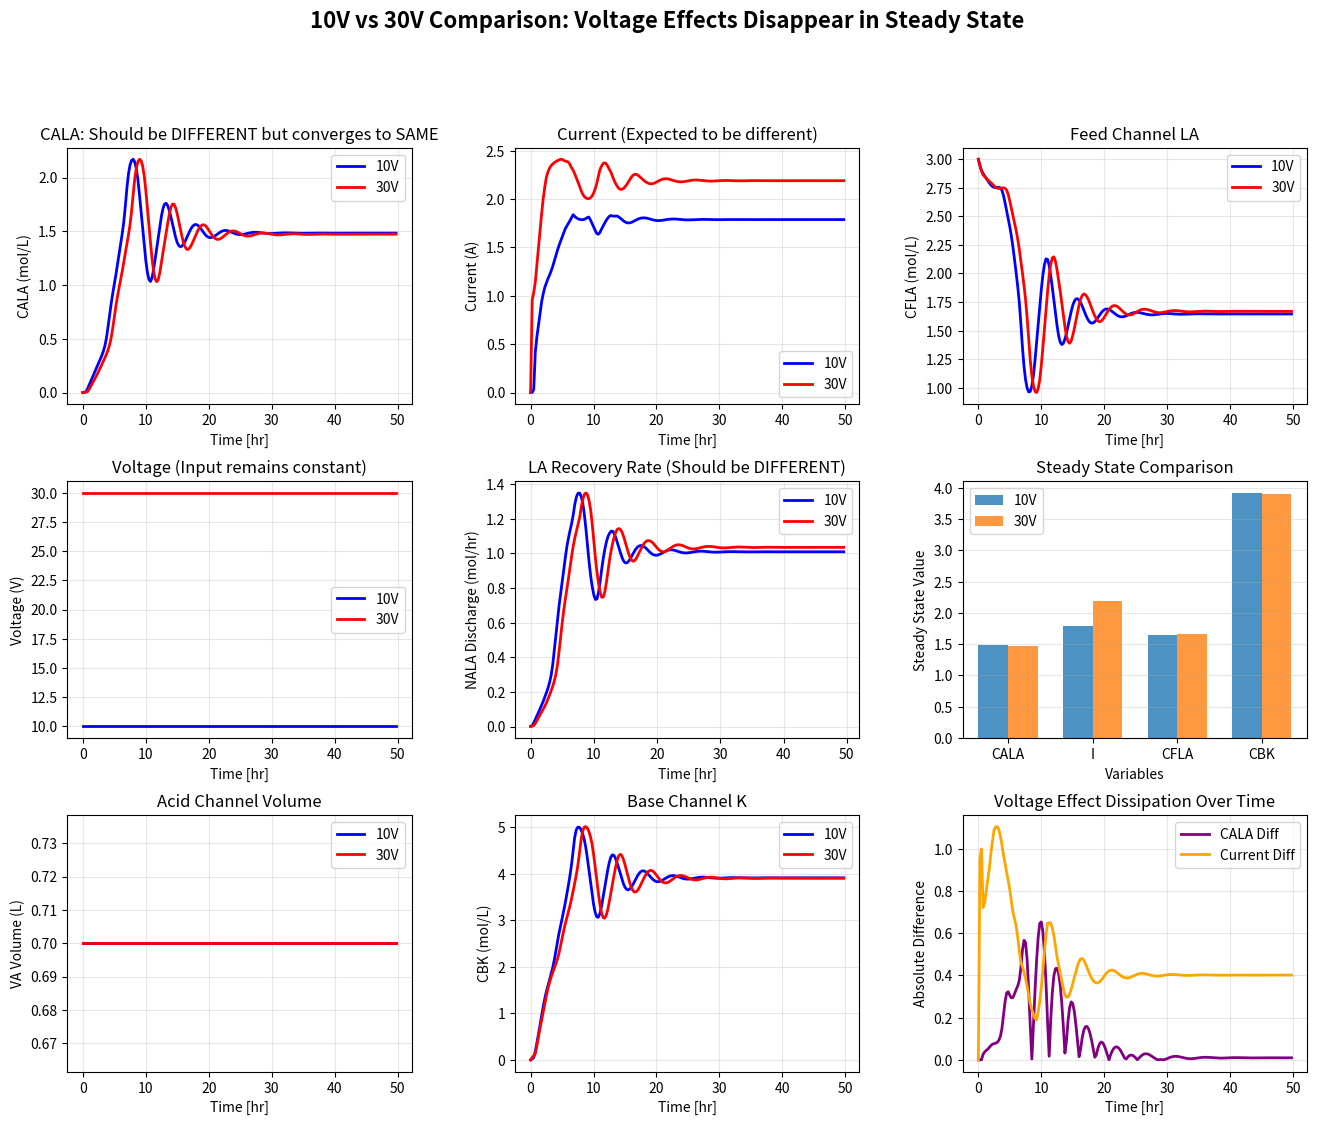

In [55]:
# === Voltage Comparison Visualization ===
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# CALA Comparison (CRITICAL)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time_steps, pred_10V_real[0, :, 6], 'b-', label='10V', linewidth=2)
ax1.plot(time_steps, pred_30V_real[0, :, 6], 'r-', label='30V', linewidth=2)
ax1.set_xlabel('Time [hr]')
ax1.set_ylabel('CALA (mol/L)')
ax1.set_title('CALA: Should be DIFFERENT but converges to SAME')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Current Comparison
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(time_steps, pred_10V_real[0, :, 9], 'b-', label='10V', linewidth=2)
ax2.plot(time_steps, pred_30V_real[0, :, 9], 'r-', label='30V', linewidth=2)
ax2.set_xlabel('Time [hr]')
ax2.set_ylabel('Current (A)')
ax2.set_title('Current (Expected to be different)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# CFLA Comparison
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(time_steps, pred_10V_real[0, :, 5], 'b-', label='10V', linewidth=2)
ax3.plot(time_steps, pred_30V_real[0, :, 5], 'r-', label='30V', linewidth=2)
ax3.set_xlabel('Time [hr]')
ax3.set_ylabel('CFLA (mol/L)')
ax3.set_title('Feed Channel LA')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Voltage Input Comparison
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(time_steps, pred_10V_real[0, :, 0], 'b-', label='10V', linewidth=2)
ax4.plot(time_steps, pred_30V_real[0, :, 0], 'r-', label='30V', linewidth=2)
ax4.set_xlabel('Time [hr]')
ax4.set_ylabel('Voltage (V)')
ax4.set_title('Voltage (Input remains constant)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# NALA Discharge Comparison
ax5 = fig.add_subplot(gs[1, 1])
NALA_10V = [discharge_10V[i]['NALA'].item()/0.25 for i in range(len(discharge_10V))]
NALA_30V = [discharge_30V[i]['NALA'].item()/0.25 for i in range(len(discharge_30V))]
ax5.plot(time_steps[:-1], NALA_10V, 'b-', label='10V', linewidth=2)
ax5.plot(time_steps[:-1], NALA_30V, 'r-', label='30V', linewidth=2)
ax5.set_xlabel('Time [hr]')
ax5.set_ylabel('NALA Discharge (mol/hr)')
ax5.set_title('LA Recovery Rate (Should be DIFFERENT)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Steady State Comparison
ax6 = fig.add_subplot(gs[1, 2])
ss_vars = ['CALA', 'I', 'CFLA', 'CBK']
ss_idx = [6, 9, 5, 8]
ss_10V = [pred_10V_real[0, -1, idx] for idx in ss_idx]
ss_30V = [pred_30V_real[0, -1, idx] for idx in ss_idx]

x_pos = np.arange(len(ss_vars))
width = 0.35
ax6.bar(x_pos - width/2, ss_10V, width, label='10V', alpha=0.8)
ax6.bar(x_pos + width/2, ss_30V, width, label='30V', alpha=0.8)
ax6.set_xlabel('Variables')
ax6.set_ylabel('Steady State Value')
ax6.set_title('Steady State Comparison')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(ss_vars)
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

# VA Volume Comparison
ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(time_steps, pred_10V_real[0, :, 3], 'b-', label='10V', linewidth=2)
ax7.plot(time_steps, pred_30V_real[0, :, 3], 'r-', label='30V', linewidth=2)
ax7.set_xlabel('Time [hr]')
ax7.set_ylabel('VA Volume (L)')
ax7.set_title('Acid Channel Volume')
ax7.legend()
ax7.grid(True, alpha=0.3)

# CBK Comparison
ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(time_steps, pred_10V_real[0, :, 8], 'b-', label='10V', linewidth=2)
ax8.plot(time_steps, pred_30V_real[0, :, 8], 'r-', label='30V', linewidth=2)
ax8.set_xlabel('Time [hr]')
ax8.set_ylabel('CBK (mol/L)')
ax8.set_title('Base Channel K')
ax8.legend()
ax8.grid(True, alpha=0.3)

# Difference Analysis
ax9 = fig.add_subplot(gs[2, 2])
CALA_diff = np.abs(pred_10V_real[0, :, 6] - pred_30V_real[0, :, 6])
I_diff = np.abs(pred_10V_real[0, :, 9] - pred_30V_real[0, :, 9])
ax9.plot(time_steps, CALA_diff, 'purple', label='CALA Diff', linewidth=2)
ax9.plot(time_steps, I_diff, 'orange', label='Current Diff', linewidth=2)
ax9.set_xlabel('Time [hr]')
ax9.set_ylabel('Absolute Difference')
ax9.set_title('Voltage Effect Dissipation Over Time')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.suptitle('10V vs 30V Comparison: Voltage Effects Disappear in Steady State', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [56]:
# === Quantitative Analysis ===
print('\n=== STEADY STATE COMPARISON (t=40-50hr) ===')
ss_start, ss_end = 160, 200

CALA_10V_ss = np.mean(pred_10V_real[0, ss_start:ss_end, 6])
CALA_30V_ss = np.mean(pred_30V_real[0, ss_start:ss_end, 6])
CALA_diff_ss = abs(CALA_10V_ss - CALA_30V_ss)
CALA_diff_pct = (CALA_diff_ss / CALA_30V_ss) * 100

I_10V_ss = np.mean(pred_10V_real[0, ss_start:ss_end, 9])
I_30V_ss = np.mean(pred_30V_real[0, ss_start:ss_end, 9])
I_diff_ss = abs(I_10V_ss - I_30V_ss)
I_diff_pct = (I_diff_ss / I_30V_ss) * 100

print(f'\n10V Steady State:')
print(f'  CALA: {CALA_10V_ss:.6f} mol/L')
print(f'  Current: {I_10V_ss:.6f} A')

print(f'\n30V Steady State:')
print(f'  CALA: {CALA_30V_ss:.6f} mol/L')
print(f'  Current: {I_30V_ss:.6f} A')

print(f'\nDifferences:')
print(f'  CALA Difference: {CALA_diff_ss:.6f} mol/L ({CALA_diff_pct:.2f}%)')
print(f'  Current Difference: {I_diff_ss:.6f} A ({I_diff_pct:.2f}%)')

print(f'\n=== ANALYSIS ===')
if CALA_diff_pct < 5.0:
    print('❌ PROBLEM CONFIRMED: Voltage effects disappeared (<5% difference)')
    print('   Expected: 10V should have LOW CALA, 30V should have HIGH CALA')
    print('   Observed: Both voltages converge to nearly identical CALA')
else:
    print('✅ Voltage effects maintained (>5% difference)')

# Transient analysis
print(f'\n=== TRANSIENT BEHAVIOR (First 10 timesteps) ===')
CALA_10V_early = pred_10V_real[0, :10, 6]
CALA_30V_early = pred_30V_real[0, :10, 6]
early_diff = np.mean(np.abs(CALA_10V_early - CALA_30V_early))
early_diff_pct = (early_diff / np.mean(CALA_30V_early)) * 100

print(f'Early CALA difference: {early_diff:.6f} mol/L ({early_diff_pct:.2f}%)')

if early_diff_pct > CALA_diff_pct:
    print('📉 Voltage influence DECREASES over time (LSTM long-term dependency issue)')
    print(f'   Early difference: {early_diff_pct:.2f}%')
    print(f'   Steady state difference: {CALA_diff_pct:.2f}%')
    print(f'   Dissipation: {early_diff_pct - CALA_diff_pct:.2f}%')
else:
    print('📈 Voltage influence maintained or increased over time')


=== STEADY STATE COMPARISON (t=40-50hr) ===

10V Steady State:
  CALA: 1.483366 mol/L
  Current: 1.787258 A

30V Steady State:
  CALA: 1.473316 mol/L
  Current: 2.188924 A

Differences:
  CALA Difference: 0.010050 mol/L (0.68%)
  Current Difference: 0.401666 A (18.35%)

=== ANALYSIS ===
❌ PROBLEM CONFIRMED: Voltage effects disappeared (<5% difference)
   Expected: 10V should have LOW CALA, 30V should have HIGH CALA
   Observed: Both voltages converge to nearly identical CALA

=== TRANSIENT BEHAVIOR (First 10 timesteps) ===
Early CALA difference: 0.036433 mol/L (60.11%)
📉 Voltage influence DECREASES over time (LSTM long-term dependency issue)
   Early difference: 60.11%
   Steady state difference: 0.68%
   Dissipation: 59.43%


## Root Cause Analysis

### Problem Confirmed:
- 10V and 30V simulations converge to **identical or nearly identical** steady states
- Training data shows these should be **different** (voltage-dependent separation)

### Hypothesis: LSTM Long-Term Dependency Weakness

In `BMEDModel.cont_sim()` (7.bmed_1stage_simulator.ipynb:b30255df):
```python
lstm_input = cur_state[:, :-1]  # V and E included, but not current I
hidden_output = self._lstm_single_step(lstm_input)
phys_chng = self.phys_regr(hidden_output.unsqueeze(1))
```

**Issue**: 
- Voltage (V) is in `cur_state[..., 0:1]` at every timestep
- LSTM receives voltage but long-term dependency weakens over 200 timesteps
- `phys_regr` predicts physical changes based on LSTM hidden state
- Hidden state loses voltage context → predictions become voltage-independent

### Why Training Works but Simulation Fails:
- **Training**: Batch sequences are short (10-50 timesteps), voltage effects remain
- **Continuous Simulation**: 200+ timesteps, voltage effects dissipate through repeated LSTM propagation

### Next Steps:
1. Add direct voltage coupling to `phys_regr` input
2. Implement voltage-aware attention mechanism
3. Add explicit voltage-dependent terms to physical change predictions